In [1]:
import pandas as pd
import seaborn as sns

from multiprocess import Pool

process_number = 6

# Empirical tests of IRLS solver for logistic regression
**Advanced Machine Learning - Project 1**

## Simple scenario without interactions

Classes are not linearly separable.

In [2]:
def perform_experiment(p, seed):
    import numpy as np
    from irls.irls import LogisticRegression
    from scipy.special import expit

    def get_data_from_model(beta_true, n, generator):
        X = generator.normal(size=(n, p))
        proba = expit(beta_true[0] + beta_true[1:] @ X.transpose())
        y = generator.binomial(1, proba)
        return X, y

    rng = np.random.default_rng(seed)
    true_beta = rng.uniform(-10, 10, (p + 1))
    X, y = get_data_from_model(true_beta, 1_000_000, rng)
    model = LogisticRegression(max_num_iters=1_000_000).fit(X, y)
    calc_beta = model.theta
    return {
        'p': p,
        'calc': calc_beta,
        'real': true_beta,
        'norm': np.linalg.norm(true_beta - calc_beta)
    }

In [3]:
how_many_betas = 100
ps = [2, 3, 4, 5, 7, 12, 18]
results = []
for p in ps:
    with Pool(process_number) as pool:
        results.extend(pool.starmap(perform_experiment, zip([p] * how_many_betas, range(how_many_betas))))

result_df = pd.DataFrame(results)

<Axes: xlabel='p', ylabel='norm'>

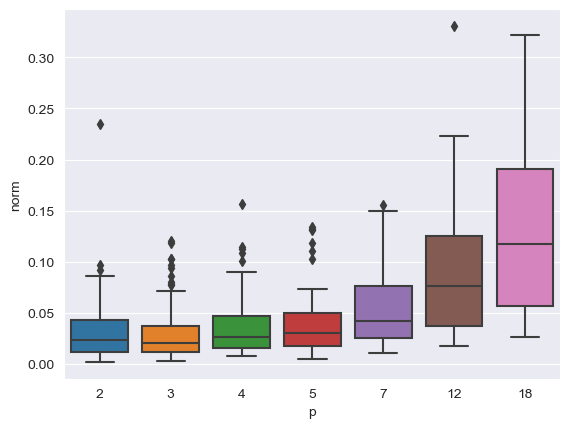

In [4]:
sns.boxplot(result_df, x="p", y="norm")

## Simple scenario with interactions

Classes are not linearly separable.

In [5]:
def perform_experiment(p, seed):
    import numpy as np
    from irls.irls import LogisticRegression
    from scipy.special import expit
    import itertools

    def get_data_from_model(beta_true, n, generator):
        X = generator.normal(size=(n, p))
        new_cols = np.stack([X[:, pair[0]] * X[:, pair[1]] for pair in interactions], axis=1)
        X_new = np.hstack([X, new_cols])
        proba = expit(beta_true[0] + beta_true[1:] @ X_new.transpose())
        y = generator.binomial(1, proba)
        return X, y

    interactions = np.stack([i for i in itertools.combinations(range(p), 2)])
    rng = np.random.default_rng(seed)
    true_beta = rng.uniform(-10, 10, (p + len(interactions) + 1))
    X, y = get_data_from_model(true_beta, 1_000_000, rng)
    model = LogisticRegression(max_num_iters=1_000_000).fit(X, y, interactions=interactions)
    calc_beta = model.theta
    return {
        'p': p,
        'calc': calc_beta,
        'real': true_beta,
        'norm': np.linalg.norm(true_beta - calc_beta)
    }

how_many_betas = 100
ps = [2, 3, 4, 5, 7, 12, 18]
results = []
for p in ps:
    with Pool(process_number) as pool:
        result = pool.starmap(perform_experiment, zip([p] * how_many_betas, range(how_many_betas)))
        results.extend(result)

result_df = pd.DataFrame(results)

<Axes: xlabel='p', ylabel='norm'>

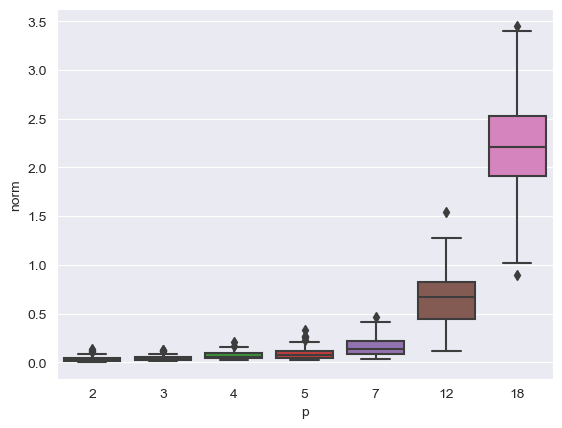

In [6]:
sns.boxplot(result_df, x="p", y="norm")